# XGBoost

In [1]:
from Functions import get_result, get_best_threshold, plot_roc_curve, save_metrics_to_json, auto_cast
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from xgboost import XGBClassifier
import json
import mlflow
import optuna
import pandas as pd

Load the datasets for training (remember they are scaled)

In [2]:
filenames = ['X_train.pkl', 'Y_train.pkl', 'X_val.pkl', 'Y_val.pkl', 'X_test.pkl', 'Y_test.pkl']
data_folder = '../data/'
dataframes = [pd.read_pickle(data_folder + filename) for filename in filenames]
X_train, Y_train, X_val, Y_val, X_test, Y_test = dataframes

#### Hyperparameter Tuning

In [3]:
# Read the JSON file
with open('../config.json', 'r') as file:
    config = json.load(file)

# Set the tracking URI for logging using the values from the JSON file
mlflow.set_tracking_uri(uri=f"http://{config['host']}:{config['port']}")

exp_name = "Credit_Card_Approval"
experiment = mlflow.get_experiment_by_name(exp_name)
exp_id = experiment.experiment_id
exp_id

'1'

In [4]:
# Set the current active MLflow experiment
mlflow.set_experiment(experiment_id=exp_id)

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1761771384696, experiment_id='1', last_update_time=1761771384696, lifecycle_stage='active', name='Credit_Card_Approval', tags={'mlflow.note.content': 'This is the Credit Card Approval project. This '
                        'experiment contains the models for credit card '
                        'approval.',
 'project_name': 'credit-card-approval'}>

In [5]:
base_run_name = "xgboost"

In [6]:
prior_runs = mlflow.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.runName LIKE '{base_run_name}%'",
    output_format="pandas",
    max_results=100,
)

print(f"Number of prior runs with base name '{base_run_name}': {len(prior_runs)}")

Number of prior runs with base name 'xgboost': 0


In [7]:
run_name = f"{base_run_name}_v{int(len(prior_runs))+1}"
run_name

'xgboost_v1'

In [8]:
# We'll need the count of each class for a hyperparameter
risk_count = Y_train.value_counts()

In [9]:
def objective(trial):
    with mlflow.start_run(nested=True):
        # Define hyperparameters
        
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),          # Number of trees
            'max_depth': trial.suggest_int('max_depth', 5, 75),                   # Maximum depth of a tree
            'learning_rate': trial.suggest_float('learning_rate', 0.1, 2.5),# Learning rate
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),                        # Fraction of samples to use per tree
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),                 # Fraction of features used per tree
            'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, 100, 250, 500, 1000,    # Control the balance of positive and negative weights (for imbalance)
                                risk_count[0]/risk_count[1]]) # Typical value to consider
        }

        # Initialize the model
        model = XGBClassifier(**params, objective='binary:logistic', eval_metric='aucpr', random_state=42)

        # Train the model
        model.fit(X_train, Y_train)

        # Evaluate the model
        preds = model.predict(X_val)
        metrics = get_result(Y_val, preds)

        # Log the parameters
        mlflow.log_params(params)
        
        # Log the metrics
        mlflow.log_metrics(metrics)

        return metrics['f1']

In [ ]:
artifact_path = "model"
# Initiate the parent run and call the hyperparameter tuning child run logic
with mlflow.start_run(experiment_id=exp_id, run_name=run_name) as parent_run:
    parent_run_id = parent_run.info.run_id
    # Initialize the Optuna study
    study = optuna.create_study(direction='maximize', study_name='XGBoost_Optimization')
    # Execute the hyperparameter optimization trials.
    study.optimize(objective, n_trials=20)

    # Log the best parameters found during the optimization
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_f1_score", study.best_value)

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "Credit Card Approval",
            "optimizer_engine": "optuna",
            "model_family": "XGBClassifier",
            "feature_set_version": 1,
            "version": int(len(prior_runs))+1
        }
    )

    model = XGBClassifier(**study.best_params, objective='binary:logistic', eval_metric='aucpr', random_state=42)
    model.fit(X_train, Y_train)

    # Log the final model
    model_info = mlflow.xgboost.log_model(model, 
                             artifact_path=artifact_path,
                             input_example=X_train.iloc[[0]]
                             )
    model_uri = model_info.model_uri

[I 2025-11-17 15:25:48,755] A new study created in memory with name: RandomForest_Optimization
[I 2025-11-17 15:25:54,542] Trial 0 finished with value: 0.0051387461459403904 and parameters: {'n_estimators': 436, 'max_depth': 55, 'learning_rate': 2.0975912402895363, 'subsample': 0.645715612233086, 'colsample_bytree': 0.9358454698349716, 'scale_pos_weight': 100}. Best is trial 0 with value: 0.0051387461459403904.


🏃 View run stylish-stork-111 at: http://127.0.0.1:8080/#/experiments/1/runs/63eee46ae3c64bda8248c328dd9f115f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-11-17 15:26:05,582] Trial 1 finished with value: 0.004051316677920324 and parameters: {'n_estimators': 962, 'max_depth': 75, 'learning_rate': 1.7264142932516438, 'subsample': 0.8324559832435798, 'colsample_bytree': 0.5376369451063743, 'scale_pos_weight': 100}. Best is trial 0 with value: 0.0051387461459403904.


🏃 View run efficient-newt-249 at: http://127.0.0.1:8080/#/experiments/1/runs/3c1b98d0b5384e63b0f4b478929824a4
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-11-17 15:26:09,830] Trial 2 finished with value: 0.0029706646862235424 and parameters: {'n_estimators': 412, 'max_depth': 13, 'learning_rate': 1.384665505445761, 'subsample': 0.6555814277414445, 'colsample_bytree': 0.9240925971724794, 'scale_pos_weight': 250}. Best is trial 0 with value: 0.0051387461459403904.


🏃 View run painted-squid-979 at: http://127.0.0.1:8080/#/experiments/1/runs/73cb82fd983e42b3b073c778a83a00a1
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-11-17 15:26:11,936] Trial 3 finished with value: 0.0033277870216306157 and parameters: {'n_estimators': 206, 'max_depth': 52, 'learning_rate': 2.146882471359856, 'subsample': 0.8306240175489661, 'colsample_bytree': 0.80402814369914, 'scale_pos_weight': 1000}. Best is trial 0 with value: 0.0051387461459403904.


🏃 View run amusing-bass-684 at: http://127.0.0.1:8080/#/experiments/1/runs/1e88c624dec848a99427dc7fa2e1253f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-11-17 15:26:14,312] Trial 4 finished with value: 0.18181818181818182 and parameters: {'n_estimators': 119, 'max_depth': 54, 'learning_rate': 0.934731222553758, 'subsample': 0.9872834181419397, 'colsample_bytree': 0.5146533389835688, 'scale_pos_weight': 1}. Best is trial 4 with value: 0.18181818181818182.


🏃 View run enchanting-shark-746 at: http://127.0.0.1:8080/#/experiments/1/runs/71f057433eb549a8a833c1bca53648f7
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-11-17 15:26:19,638] Trial 5 finished with value: 0.002574002574002574 and parameters: {'n_estimators': 420, 'max_depth': 63, 'learning_rate': 1.5032563616363912, 'subsample': 0.6409217307492512, 'colsample_bytree': 0.6488690594831068, 'scale_pos_weight': 500}. Best is trial 4 with value: 0.18181818181818182.


🏃 View run bustling-pig-536 at: http://127.0.0.1:8080/#/experiments/1/runs/efb50b7335a44fd7a062146e8190712e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-11-17 15:27:16,682] Trial 6 finished with value: 0.13333333333333333 and parameters: {'n_estimators': 700, 'max_depth': 52, 'learning_rate': 1.383379065829305, 'subsample': 0.8403532902868254, 'colsample_bytree': 0.5943767841803873, 'scale_pos_weight': 1}. Best is trial 4 with value: 0.18181818181818182.


🏃 View run agreeable-loon-609 at: http://127.0.0.1:8080/#/experiments/1/runs/b88bddae2dc545718209620db88d27b3
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-11-17 15:27:36,738] Trial 7 finished with value: 0.009234828496042216 and parameters: {'n_estimators': 681, 'max_depth': 7, 'learning_rate': 1.0925704183773495, 'subsample': 0.9196985791627793, 'colsample_bytree': 0.7972972023463374, 'scale_pos_weight': 100}. Best is trial 4 with value: 0.18181818181818182.


🏃 View run receptive-ray-839 at: http://127.0.0.1:8080/#/experiments/1/runs/c89939ba33d14ead88531bef99fe92cf
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-11-17 15:27:48,387] Trial 8 finished with value: 0.0012953367875647669 and parameters: {'n_estimators': 610, 'max_depth': 55, 'learning_rate': 2.4150388645601057, 'subsample': 0.9207224242296396, 'colsample_bytree': 0.5435607816003654, 'scale_pos_weight': 100}. Best is trial 4 with value: 0.18181818181818182.


🏃 View run rebellious-snake-56 at: http://127.0.0.1:8080/#/experiments/1/runs/a0f625ad24bd43f28a2e5c0512283f4b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-11-17 15:28:06,687] Trial 9 finished with value: 0.15384615384615385 and parameters: {'n_estimators': 267, 'max_depth': 18, 'learning_rate': 0.23283256113758438, 'subsample': 0.6326335726895682, 'colsample_bytree': 0.8256293177672698, 'scale_pos_weight': 1}. Best is trial 4 with value: 0.18181818181818182.


🏃 View run unequaled-swan-610 at: http://127.0.0.1:8080/#/experiments/1/runs/2b746389be7042f2a3afaaa9c28fb098
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-11-17 15:28:15,529] Trial 10 finished with value: 0.005044136191677175 and parameters: {'n_estimators': 158, 'max_depth': 30, 'learning_rate': 0.5211400934176079, 'subsample': 0.5111446588581007, 'colsample_bytree': 0.7237192137715499, 'scale_pos_weight': 707.9454545454546}. Best is trial 4 with value: 0.18181818181818182.


🏃 View run thundering-ant-326 at: http://127.0.0.1:8080/#/experiments/1/runs/ade0996fbbc94367ae0f871fb8720258
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-11-17 15:28:53,242] Trial 11 finished with value: 0.14035087719298245 and parameters: {'n_estimators': 104, 'max_depth': 29, 'learning_rate': 0.13511468518970737, 'subsample': 0.522975286783288, 'colsample_bytree': 0.8626246716499024, 'scale_pos_weight': 1}. Best is trial 4 with value: 0.18181818181818182.


🏃 View run likeable-bear-793 at: http://127.0.0.1:8080/#/experiments/1/runs/90696eed2e504d46b3903ac873a54e48
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-11-17 15:30:50,707] Trial 12 finished with value: 0.11940298507462686 and parameters: {'n_estimators': 282, 'max_depth': 34, 'learning_rate': 0.8556593188415124, 'subsample': 0.9831493653070045, 'colsample_bytree': 0.6986551468217819, 'scale_pos_weight': 1}. Best is trial 4 with value: 0.18181818181818182.


🏃 View run bouncy-pig-611 at: http://127.0.0.1:8080/#/experiments/1/runs/90515447211740449d1d44ad4ce7d3f0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-11-17 15:31:55,719] Trial 13 finished with value: 0.14705882352941177 and parameters: {'n_estimators': 315, 'max_depth': 18, 'learning_rate': 0.11733301935031376, 'subsample': 0.7266286930592614, 'colsample_bytree': 0.9842979717054963, 'scale_pos_weight': 1}. Best is trial 4 with value: 0.18181818181818182.


🏃 View run tasteful-moth-423 at: http://127.0.0.1:8080/#/experiments/1/runs/65106bcb450e4c3b9d9f76b3ee05f247
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-11-17 15:32:49,075] Trial 14 finished with value: 0.11764705882352941 and parameters: {'n_estimators': 265, 'max_depth': 42, 'learning_rate': 0.5833913635518752, 'subsample': 0.5776660127425465, 'colsample_bytree': 0.8145663239815767, 'scale_pos_weight': 1}. Best is trial 4 with value: 0.18181818181818182.


🏃 View run bald-ray-512 at: http://127.0.0.1:8080/#/experiments/1/runs/f6317348663d44ca9d7c9a790464b633
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-11-17 15:33:57,842] Trial 15 finished with value: 0.2073170731707317 and parameters: {'n_estimators': 105, 'max_depth': 21, 'learning_rate': 0.5521376747785309, 'subsample': 0.7479184373856762, 'colsample_bytree': 0.6487661510061823, 'scale_pos_weight': 250}. Best is trial 15 with value: 0.2073170731707317.


🏃 View run fun-fly-257 at: http://127.0.0.1:8080/#/experiments/1/runs/0b09b0e69a794c62b7bf71bb82af52cf
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-11-17 15:34:47,893] Trial 16 finished with value: 0.003351379221448827 and parameters: {'n_estimators': 100, 'max_depth': 42, 'learning_rate': 0.8243120548483098, 'subsample': 0.7616306670047405, 'colsample_bytree': 0.6416114986061094, 'scale_pos_weight': 250}. Best is trial 15 with value: 0.2073170731707317.


🏃 View run hilarious-hound-937 at: http://127.0.0.1:8080/#/experiments/1/runs/9f641bee15af482c96dfd9312ded248e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-11-17 15:35:55,742] Trial 17 finished with value: 0.005747126436781609 and parameters: {'n_estimators': 857, 'max_depth': 66, 'learning_rate': 0.955908856605246, 'subsample': 0.7393428102976044, 'colsample_bytree': 0.5017201840265253, 'scale_pos_weight': 250}. Best is trial 15 with value: 0.2073170731707317.


🏃 View run capable-frog-197 at: http://127.0.0.1:8080/#/experiments/1/runs/7c5b47626998409fa4e04686e3bfcfc5
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-11-17 15:39:28,554] Trial 18 finished with value: 0.2732919254658385 and parameters: {'n_estimators': 521, 'max_depth': 24, 'learning_rate': 0.592163786154168, 'subsample': 0.9953333785206998, 'colsample_bytree': 0.6081573856287199, 'scale_pos_weight': 1000}. Best is trial 18 with value: 0.2732919254658385.


🏃 View run intrigued-fish-556 at: http://127.0.0.1:8080/#/experiments/1/runs/8b9c21ec210d482fb2182755e10bc18b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-11-17 15:40:22,844] Trial 19 finished with value: 0.004265632573921474 and parameters: {'n_estimators': 528, 'max_depth': 21, 'learning_rate': 0.5343101950345974, 'subsample': 0.8944506659999202, 'colsample_bytree': 0.60472427725248, 'scale_pos_weight': 1000}. Best is trial 18 with value: 0.2732919254658385.


🏃 View run glamorous-conch-858 at: http://127.0.0.1:8080/#/experiments/1/runs/41763bf3a18741dcacbc1f9ada0b81ef
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


2025/11/17 15:44:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred sche

🏃 View run xgboost_v1 at: http://127.0.0.1:8080/#/experiments/1/runs/bff49afb02be4f90805dbc17b4e5e76e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


In [11]:
print(f'parent_run_id: {parent_run_id}')
print(f'model_uri: {model_uri}')

parent_run_id: bff49afb02be4f90805dbc17b4e5e76e
model_uri: models:/m-06e8f06513814103a79ed5f5ea572b65


In [12]:
runs = mlflow.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.parentRunId = '{parent_run_id}'",
    output_format='pandas'
)

In [13]:
param_cols = [c for c in runs.columns if c.startswith("params.")]

display(runs[[
    'run_id', 
    'metrics.f1', 
    'metrics.recall', 
    'metrics.precision',
    'metrics.accuracy'
    ] + param_cols]
    .sort_values(by='metrics.f1', ascending=False)
    .head(10))

,run_id,metrics.f1,metrics.recall,metrics.precision,metrics.accuracy,params.scale_pos_weight,params.subsample,params.colsample_bytree,params.max_depth,params.n_estimators,params.learning_rate
1,8b9c21ec210d482fb2182755e10bc18b,0.273292,0.458333,0.194690,0.996571,1000,0.9953333785206998,0.6081573856287199,24,521,0.592163786154168
4,0b09b0e69a794c62b7bf71bb82af52cf,0.207317,0.354167,0.146552,0.996190,250,0.7479184373856762,0.6487661510061823,21,105,0.5521376747785309
15,71f057433eb549a8a833c1bca53648f7,0.181818,0.125000,0.333333,0.998417,1,0.9872834181419397,0.5146533389835688,54,119,0.934731222553758
10,2b746389be7042f2a3afaaa9c28fb098,0.153846,0.104167,0.294118,0.998388,1,0.6326335726895682,0.8256293177672698,18,267,0.23283256113758438
6,65106bcb450e4c3b9d9f76b3ee05f247,0.147059,0.104167,0.250000,0.998300,1,0.7266286930592614,0.9842979717054963,18,315,0.11733301935031376
8,90696eed2e504d46b3903ac873a54e48,0.140351,0.083333,0.444444,0.998564,1,0.522975286783288,0.8626246716499024,29,104,0.13511468518970737
13,b88bddae2dc545718209620db88d27b3,0.133333,0.104167,0.185185,0.998095,1,0.8403532902868254,0.5943767841803873,52,700,1.383379065829305
7,90515447211740449d1d44ad4ce7d3f0,0.119403,0.083333,0.210526,0.998271,1,0.9831493653070045,0.6986551468217819,34,282,0.8556593188415124
5,f6317348663d44ca9d7c9a790464b633,0.117647,0.083333,0.200000,0.998241,1,0.5776660127425465,0.8145663239815767,42,265,0.5833913635518752
12,c89939ba33d14ead88531bef99fe92cf,0.009235,0.145833,0.004768,0.955976,100,0.9196985791627793,0.7972972023463374,7,681,1.0925704183773495


From the above results we see that all the models with 1.0 scale_pos_weight lays in the lower end compared to the higher ones. Since we have a imbalanced dataset, this make good sense.

Lets take the parameters that resulted in the best performance and test it on our test set and see how well it is doing.

In [14]:
loaded_model = mlflow.xgboost.load_model(model_uri)

In [15]:
# Predict on the val set
val_predictions = loaded_model.predict_proba(X_val)[:, 1]

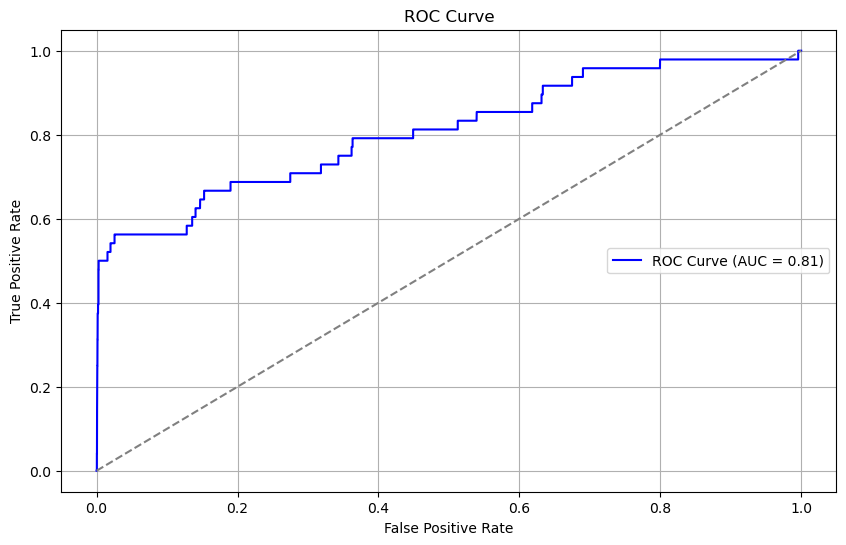

0.8085430730848253

In [16]:
plot_roc_curve(Y_val, val_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:74: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


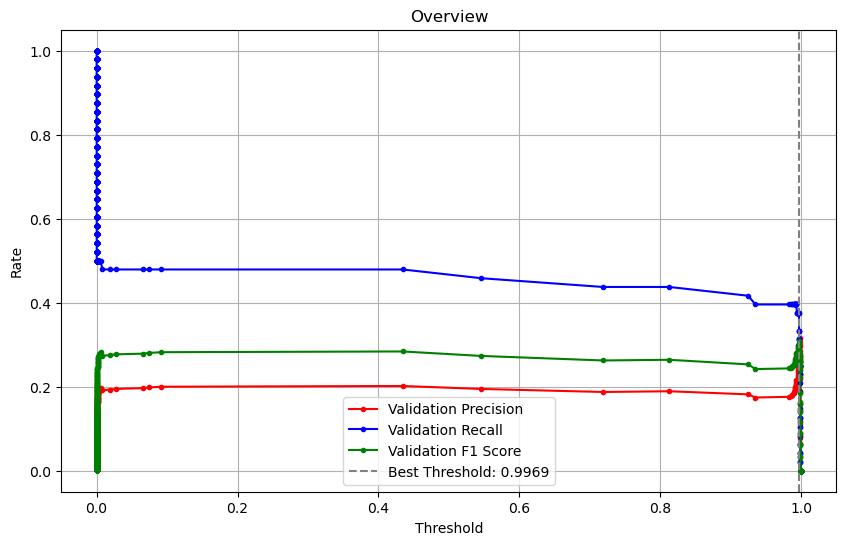

In [17]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)

In [18]:
# Predict on the test set
test_predictions = loaded_model.predict_proba(X_test)[:, 1]

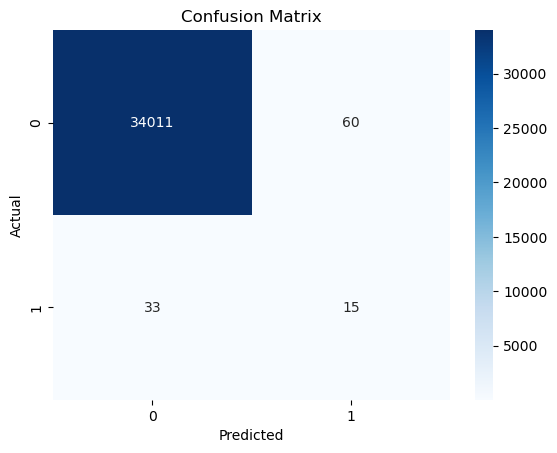

Accuracy     = 1.0
Recall       = 0.31
Precision    = 0.2
F1           = 0.24


In [19]:
result_1 = get_result(Y_test, test_predictions, best_threshold, visualize=True)

Lets merge the training and validation set and predict on the test set to see if the model can perform better with more training data. We'll keep the best threshold, since the model now have seen the data to construct the best threshold. However, I do not think the threshold can get much closer to 1.

In [20]:
best_run = mlflow.get_run(parent_run_id)
best_params = best_run.data.params
best_params = {k: auto_cast(v) for k, v in best_params.items()}
best_params

{'n_estimators': 521,
 'max_depth': 24,
 'learning_rate': 0.592163786154168,
 'subsample': 0.9953333785206998,
 'colsample_bytree': 0.6081573856287199,
 'scale_pos_weight': 1000}

In [21]:
# Initialize the RandomForestClassifier with the best hyperparameters from the tuning phase
xgb = XGBClassifier(**best_params, eval_metric="aucpr", random_state=42)

In [22]:
# Train the model
xgb.fit(pd.concat([X_train, X_val]), pd.concat([Y_train, Y_val]))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6081573856287199, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.592163786154168,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=24, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=521, n_jobs=None,
              num_parallel_tree=None, ...)

In [23]:
# Predict on the val set
val_predictions = xgb.predict_proba(X_val)[:, 1]

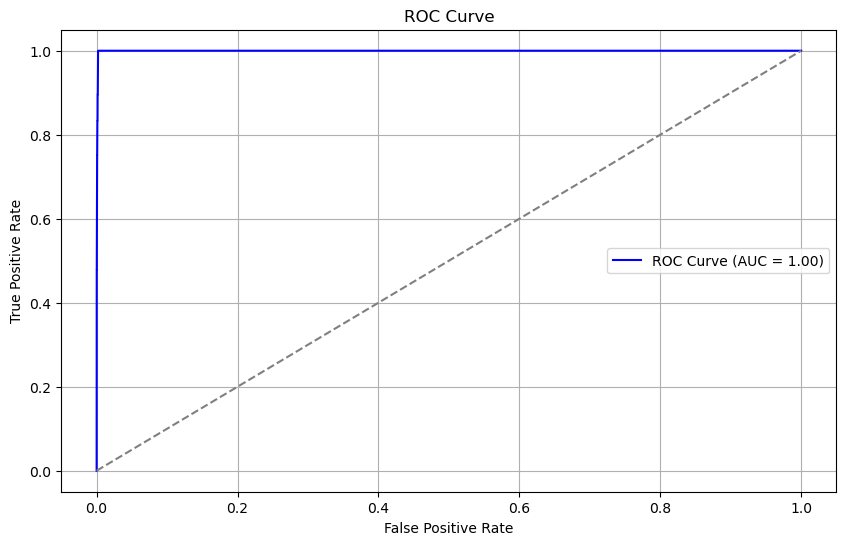

0.9995426083553468

In [24]:
plot_roc_curve(Y_val, val_predictions)

It does perfect on the ROC Curve, which is not surprising, since the model has been trained on the data

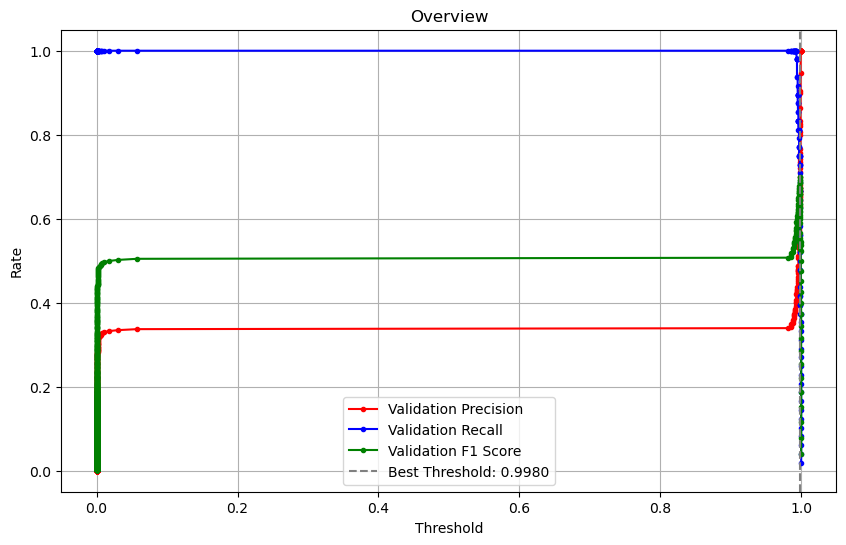

In [25]:
_ = get_best_threshold('Validation', Y_val, val_predictions)

In [26]:
# Predict on the test set
test_predictions = xgb.predict_proba(X_test)[:, 1]

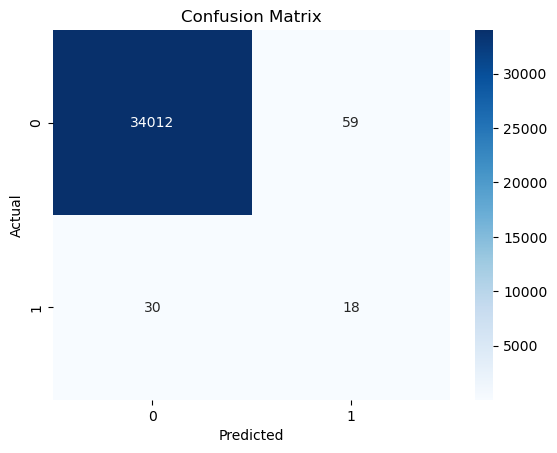

Accuracy     = 1.0
Recall       = 0.38
Precision    = 0.23
F1           = 0.29


In [27]:
result_2 = get_result(Y_test, test_predictions, best_threshold, visualize=True)

In [28]:
if result_2['f1'] > result_1['f1']:
    print('By training our model on more data, we achived a higher performance on the F1 score')
else:
    print('The first model we found, through hyperparameter tuning, is still our best model on the F1 score.')
    print('It had the following scores:')
    print('Recall       =', round(result_1['recall'], 2))
    print('Precision    =', round(result_1['precision'], 2))
    print('F1           =', round(result_1['f1'], 2))

By training our model on more data, we achived a higher performance on the F1 score
